In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import Clean_data as cld
import Transform_Data as tfd
import Visualize_Data as vld
from scipy import stats

# Exploring an Ideal Job, based on Location

## The Story So far
I have gone through my datasets, starting with 30 sets, which resulted in around 40 extrapolated discoveries.

From those 40 sets I have pruned back to less than 10 sets with a much narrower focus on:

Region: How enticing a particular area is for a prospective worker
this is based on:
* Affordability
* Household Income
* Opportunities
* Average Debt
* Rent/Mortgage to Income Ratio

Field: A combined look at degrees and industries that are likely to help secure good financial standing
This is currently based on the demand for the field as well as the salary.


## Exploration of datasets

In [2]:
field_starting_salaries = pd.read_csv('Final_Data/field_starting_salaries.csv')
region_starting_salaries = pd.read_csv('Final_Data/Regional_starting_salaries.csv')
state_field_scores = pd.read_csv('Final_Data/state_field_scores.csv')
state_rank_grp= pd.read_csv('Final_Data/Grouped_State_Ranks.csv')
df =  pd.read_csv('Final_Data/Full_Weighted_States.csv')

In [3]:
def run_zscore(df, cols):
    print(df.columns)
    df = df[cols]
    length = len(df)
    samp = int(length/15)
    print('full length ',length)
    print('sample size ',samp)
    print('zscore ',stats.zscore(df).sample(samp).mean())

In [21]:
field_starting_salaries.head(5)

,field,field_Starting Median Salary,field_Mid-Career Median Salary,field_start_over_min_w,field_mid_over_min_w
0,"Architecture, Design",41775.000000,69675.000000,2.770225,4.620358
1,"Business, Admin, PR",43828.571429,80942.857143,2.906404,5.367563
2,"Consumer, Retail, Arts, Humanities",36420.000000,61030.000000,2.415119,4.047082
3,"Health, Education, Government, Civil",40740.000000,62820.000000,2.701592,4.165782
4,"Science, Technology, Engineering",48904.166667,82066.666667,3.242982,5.442087


In [4]:

field_starting_salaries.columns = ['field', 'field_Starting Median Salary', 'field_Mid-Career Median Salary',
                                   'Percent change from Starting to Mid-Career Salary','field_start_over_min_w', 'field_mid_over_min_w']
field_starting_salaries = field_starting_salaries[['field', 'field_Starting Median Salary', 'field_Mid-Career Median Salary','field_start_over_min_w', 'field_mid_over_min_w']]

In [5]:
region_starting_salaries.columns = ['Region', 'region_Starting Median Salary', 'region_Mid-Career Median Salary','region_start_over_min_w', 'region_mid_over_min_w']

In [6]:
state_field_scores.head(3)

,state,field,ratio,score
0,District of Columbia,"Science, Technology, Engineering",0.485053,24.075448
1,Washington,"Science, Technology, Engineering",0.421292,23.934516
2,California,"Science, Technology, Engineering",0.416775,23.923738


In [7]:
run_zscore(state_field_scores, ['ratio', 'score'])

Index(['state', 'field', 'ratio', 'score'], dtype='object')
full length  255
sample size  17
zscore  ratio    0.254964
score    0.236229
dtype: float64


In [8]:
state_rank_grp.head(3)

,State,Region,affordability,education,earnings,summed
0,Pennsylvania,Northeastern,38,44,50,132
1,Iowa,Midwestern,51,39,36,126
2,Texas,Southern,41,31,51,123


In [9]:
df = df[['StateAbbreviation', 'State']]

In [10]:
df.head(3)

,StateAbbreviation,State
0,NY,New York
1,CA,California
2,TX,Texas


With my top-level dataframe in hand, it's time to pair some data

In [11]:
df = df.merge(state_field_scores, left_on='State', right_on='state')
df = df.merge(field_starting_salaries, left_on='field', right_on='field')
df = df.merge(state_rank_grp, left_on='State', right_on='State')
df = df.merge(region_starting_salaries, left_on='Region', right_on='Region')

In [12]:

df = df.dropna()

In [13]:
df['score'] =(df['score'].rank(method='dense')) ** 1/3
df['field_start_over_min_w'] = df['field_start_over_min_w'].rank(method='dense')
df['field_mid_over_min_w'] = df['field_start_over_min_w'].rank(method='dense')
df['summed'] = df['summed'].rank(method='dense')
df['region_start_over_min_w'] = df['region_start_over_min_w'].rank(method='dense')
df['region_mid_over_min_w'] = df['region_mid_over_min_w'].rank(method='dense')

df = df[['State', 'field', 'Region','field_start_over_min_w','field_mid_over_min_w', 'summed', 'region_start_over_min_w','region_mid_over_min_w', 'score']]
df['final_score'] = df['field_start_over_min_w']*df['field_mid_over_min_w'] *df['summed'] * df['region_start_over_min_w'] * df['region_mid_over_min_w']*df['score']
df['final_score']  = np.log(df['final_score'])

In [14]:
df.head(3)

,State,field,Region,field_start_over_min_w,field_mid_over_min_w,summed,region_start_over_min_w,region_mid_over_min_w,score,final_score
0,New York,"Science, Technology, Engineering",Northeastern,5.0,5.0,8.0,4.0,4.0,77.000000,12.414712
1,New York,"Business, Admin, PR",Northeastern,4.0,4.0,8.0,4.0,4.0,55.333333,11.637994
2,New York,"Consumer, Retail, Arts, Humanities",Northeastern,1.0,1.0,8.0,4.0,4.0,52.000000,8.803274


In [15]:
cols = ['score', 'field_start_over_min_w', 'field_mid_over_min_w','region_start_over_min_w', 'region_mid_over_min_w','final_score']
run_zscore(df, cols)

Index(['State', 'field', 'Region', 'field_start_over_min_w',
       'field_mid_over_min_w', 'summed', 'region_start_over_min_w',
       'region_mid_over_min_w', 'score', 'final_score'],
      dtype='object')
full length  250
sample size  16
zscore  score                      0.180135
field_start_over_min_w     0.132583
field_mid_over_min_w       0.132583
region_start_over_min_w   -0.340909
region_mid_over_min_w     -0.340909
final_score               -0.059138
dtype: float64


In [16]:
df_scored =df[['State', 'field', 'Region','final_score']]

In [17]:
df_scored.sort_values(by='final_score', ascending= False).head(20)

,State,field,Region,final_score
5,Pennsylvania,"Science, Technology, Engineering",Northeastern,14.111161
10,Massachusetts,"Science, Technology, Engineering",Northeastern,13.898748
15,New Jersey,"Science, Technology, Engineering",Northeastern,13.673486
50,Texas,"Science, Technology, Engineering",Southern,13.534009
90,Virginia,"Science, Technology, Engineering",Southern,13.456332
60,North Carolina,"Science, Technology, Engineering",Southern,13.440090
6,Pennsylvania,"Business, Admin, PR",Northeastern,13.377192
25,Connecticut,"Science, Technology, Engineering",Northeastern,13.296877
70,Tennessee,"Science, Technology, Engineering",Southern,13.266983
45,California,"Science, Technology, Engineering",California,13.254488


After totaling, combining and scoring, it still appears that pennsylvania takes the lead

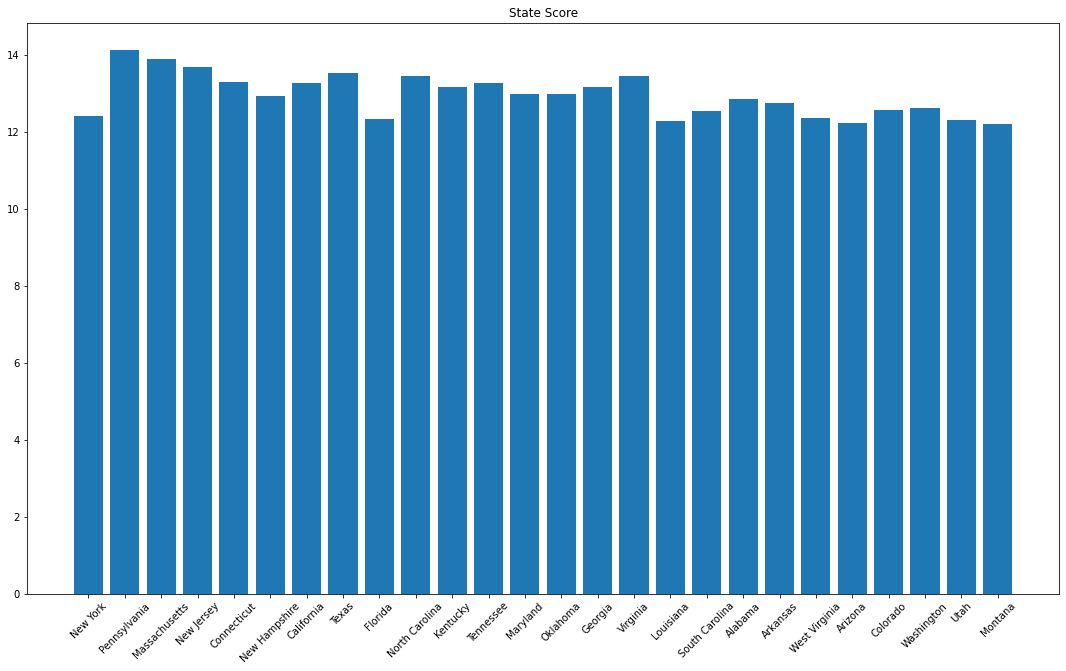

In [18]:
#Create
fig, ax = plt.subplots()
#Data
df_h = df_scored[df_scored['final_score'] > 12]
x1 = df_h['State']
y1 =df_h['final_score'] 
#Appearance

ax.bar(x1, y1,label='Regions')
ax.set_title("State Score")  # Add a title to the axes.
fig.set_size_inches(18.5, 10.5)
plt.xticks(rotation=45)
plt.show()

In [19]:
df_scored.groupby('Region').mean()

,final_score
Region,
California,9.950738
Midwestern,9.049957
Northeastern,10.269563
Southern,10.651684
Western,9.358835
